We want to create a figure of two figures:


A)figure that shows a satelite-aligned keogram with overplotted velocity field measurements and mag measurementsalongside a plot of the Magnetic, velocity fields and the pixel intensity


B)plot of the Magnetic, velocity fields and the pixel intensity and the periodogram of B

D) Combine the three


Initalize Cell 1-9


In [1]:
import importlib
import os

if importlib.util.find_spec('asilib') is None:
    !pip install asilib
import numpy as np
print(np.__version__)
if int(np.__version__[0]) > 1:
  os.kill(os.getpid(), 9) #asilib requires numpy 1.26, but the cloud initially
  #forced to numpy 2.0, to fix this we kill it THIS REQUIRES YOU TO RUN TWICE

  for pkg in ['scienceplots', 'viresclient', 'geopack']:
    if importlib.util.find_spec(pkg) is None:
        !pip install {pkg}

1.26.4


In [2]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp
from scipy.signal import periodogram

import scienceplots

plt.style.use(['science', 'no-latex'])
alt=150
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["black", "r", "m", "g"])  #changes default colou

Load IGRF coefficients ...


In [3]:
time_array=(datetime(2022,12,19,14,2), datetime(2022,12,19,14,8))

In [4]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6), **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [5]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [6]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [7]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_inverse_scipy(q):
    # Ensure q is a numpy array
    q = np.asarray(q)

    # Create a Rotation object from the quaternion
    rotation = R.from_quat(q)  # Note: scipy uses [x, y, z, w] format

    # Compute the inverse rotation
    inverse_rotation = rotation.inv()


    return inverse_rotation

In [8]:

def find_closest_indices(times1, times2):
    # Convert to numpy arrays
    times1 = np.array(times1)
    times2 = np.array(times2)

    # Compute the differences between each time in times1 and all times in times2
    # Resulting in a 2D array where each row contains the absolute differences for one time in times1
    differences = np.abs(times1[:, None] - times2)

    # Find the index of the minimum difference for each time in times1
    closest_indices = np.argmin(differences, axis=1)

    return closest_indices

In [9]:

from scipy.optimize import curve_fit
import geopack.geopack as gp
def footprint(time, latitude, longitude, altitude, alt,vsw= [-400,0,0]):
    """
    time, datetime, time for magnetic data for footprint
    vsw velocity of solar wind, tuple of x,y,z
    longitude of satellite in degrees
    latitude of satellite in degrees
    altitude of satellite in km from centre of earth (should be above ~6371)
    THIS CODE ONLY Works in the NOrthern hemisphere

    """
    def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
    def x(t, params_x):
        return cubic(t, *params_x)

    def y(t, params_y):
        return cubic(t, *params_y)

    def z(t, params_z):
        return cubic(t, *params_z)
    def radius(t, params_x, params_y, params_z):
        return np.sqrt(x(t, params_x)**2 + y(t, params_y)**2 + z(t, params_z)**2)

    def curve_fit_func(xx,yy,zz, differencealt):

        r = np.linspace(1, 1.5, 10000)# construct an array of radiuses from 1-1.5

        radius_data=np.sqrt(xx**2+yy**2+zz**2)

        params_x, _ = curve_fit(cubic, radius_data, xx) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy)
        params_z, _ = curve_fit(cubic, radius_data, zz)



        index_closest=np.argmin(np.abs(radius(r, params_x, params_y, params_z)-(alt-differencealt+6371)/6371))#Find the index that produces the closest radius to the altitude

        return x(r[index_closest],params_x ),y(r[index_closest],params_y ),z(r[index_closest],params_z )

    t1 = time
    t0 = datetime(1970,1,1) #epoch
    ut = (t1-t0).total_seconds()
    lat_sat=np.deg2rad(latitude)
    lon_sat=np.deg2rad(longitude) #converts to radii
    gp.recalc(ut)
    r, theta= gp.geodgeo(altitude,lat_sat,1) #this r accounts for earths oblateness, so we need to find the difference between my 6371 assumption and the real value and account for that
    differencearray= (altitude+6371)-r
    x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian


    x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

    x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array
    for index in range(len(x_gsm)):
        x_foot_int, y_foot_int, z_foot_int, xx2, yy2,zz2 = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=3, maxloop=1000 ) #traces each set of lat,lon,alt outward


        x_foot[index],y_foot[index],z_foot[index] = curve_fit_func(xx2,yy2,zz2, differencearray[index])




    x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

    alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
    for index in range(len(x_done)):

        r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

        alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

    print(alt_sat_done, 'altitude derived from fit')

    if np.any(np.abs(alt_sat_done - alt) > 5):
        raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
    print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
    sat_lla=np.array([ np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360,  alt_sat_done])
    return sat_lla

Getting B Data

In [10]:
#Now we need to set our token, for my case to protect my token I import from a file not in the github cloud, however you can just paste your code from viresclient, just don't share it publically!
set_token(
        "https://vires.services/ows",
        set_default=True,
        token="kmxv5mTTyYwzw4kQ9lsCkGfQHtjjJRVZ",
    )  # key


Token saved for https://vires.services/ows


In [11]:
#Lets do B first
ds = requester(
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True,
    asynchronous=False,
    show_progress=False)
BNEC=ds["B_NEC_res_CHAOS"]
Btime = BNEC.index.to_numpy()
BNEC = arrangement(Btime, ds["B_NEC_res_CHAOS"], 3)


latitude_B, longitude_B, altitude_B = ds['Latitude'].to_numpy(), ds['Longitude'].to_numpy(),  (ds["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data

<ipython-input-5-f085a82805a5>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  barranged[j][k] = array[j][k]


Get velocity Data from Swarm B

In [12]:
measurements_E = [
        "Vixv",
        "Viy",
        "Viz",
    ]
dsE = requester(
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True,
    asynchronous=False,
    show_progress=False)
dsB = requester(
    'SW_OPER_MAGB_HR_1B', #Mag B, high resolution, 50Hz B (Magnetic field)
    ["q_NEC_CRF"], #Magnetic field in NEC coordinates
    False,
    asynchronous=False,
    show_progress=False)

latitude_E, longitude_E, altitude_E = dsE['Latitude'].to_numpy(), dsE['Longitude'].to_numpy(),  (dsE["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data


Footprint satellite data from ~500km to 150km

In [13]:
sat_lla_B=footprint(time_array[0], latitude_B, longitude_B, altitude_B, alt, vsw=[-345,12,-12])
#This can take 10+ minutes, sry but I wanted to make my own pythonic-based footprinter


[150.23400186 150.23355869 150.23311411 ... 150.26311388 150.26340127
 150.26370579] altitude derived from fit
[-117.86933246 -117.86912417 -117.86891592 ... -117.00649309 -117.00639648
 -117.00629924] [65.92698498 65.92575418 65.92452328 ... 58.56735635 58.56613272
 58.56490916] lat and lon


In [14]:
#This large of an array makes google collab unhappy, so we write this to disc
sat_lla_B = np.memmap('satellitedata.dat', dtype='float32', mode='w+', shape=np.shape(sat_lla_B))

Some post processing to get directions correct and in a numpy array

In [15]:
indicies=find_closest_indices(dsE.index, dsB.index)
quatnecrf=dsB["q_NEC_CRF"].to_numpy()[indicies]
quaternions = []
vsat=np.array([dsE["Vixv"] , dsE["Viy"], dsE["Viz"]]).T

Etime = dsE.index

VNEC=[]
for i in range(len(quatnecrf)):
    inverse_quat = quaternion_inverse_scipy(dsB["q_NEC_CRF"].to_numpy()[indicies][i])

    rot_NEC_V= inverse_quat.apply(vsat[i])
    VNEC.append(rot_NEC_V)



VNEC=np.array(VNEC)


Given an issue with the velocity data for this event, (see github link), the velocity data is corrected to the mag position is right. This will lead to a 5m error but is better than 10km off.

In [16]:
from scipy.interpolate import CubicSpline
cs_lat = CubicSpline( Btime, sat_lla_B[0]) #B footprint data
cs_lon = CubicSpline( Btime, sat_lla_B[1])
cs_alt = CubicSpline( Btime, sat_lla_B[2])

#sat_lla_E=footprint(time_array[0], latitude_E, longitude_E, altitude_E, alt, vsw=[-345,12,-12])
sat_lla_E= np.array([cs_lat(Etime), cs_lon(Etime),  cs_alt(Etime)]) #km  # Gets Emphermis data latitude, longitude, altitude for times in E FROM B position


Finally!, lets initalize our imager for the given range in the initalization

In [17]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time_range=time_array, colors='rgb', )


Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


Lets just double check everything looks good (ie we get a good photo with the satellite position correct)

Text(0.5, 1.0, '07:05:39 Local Time')

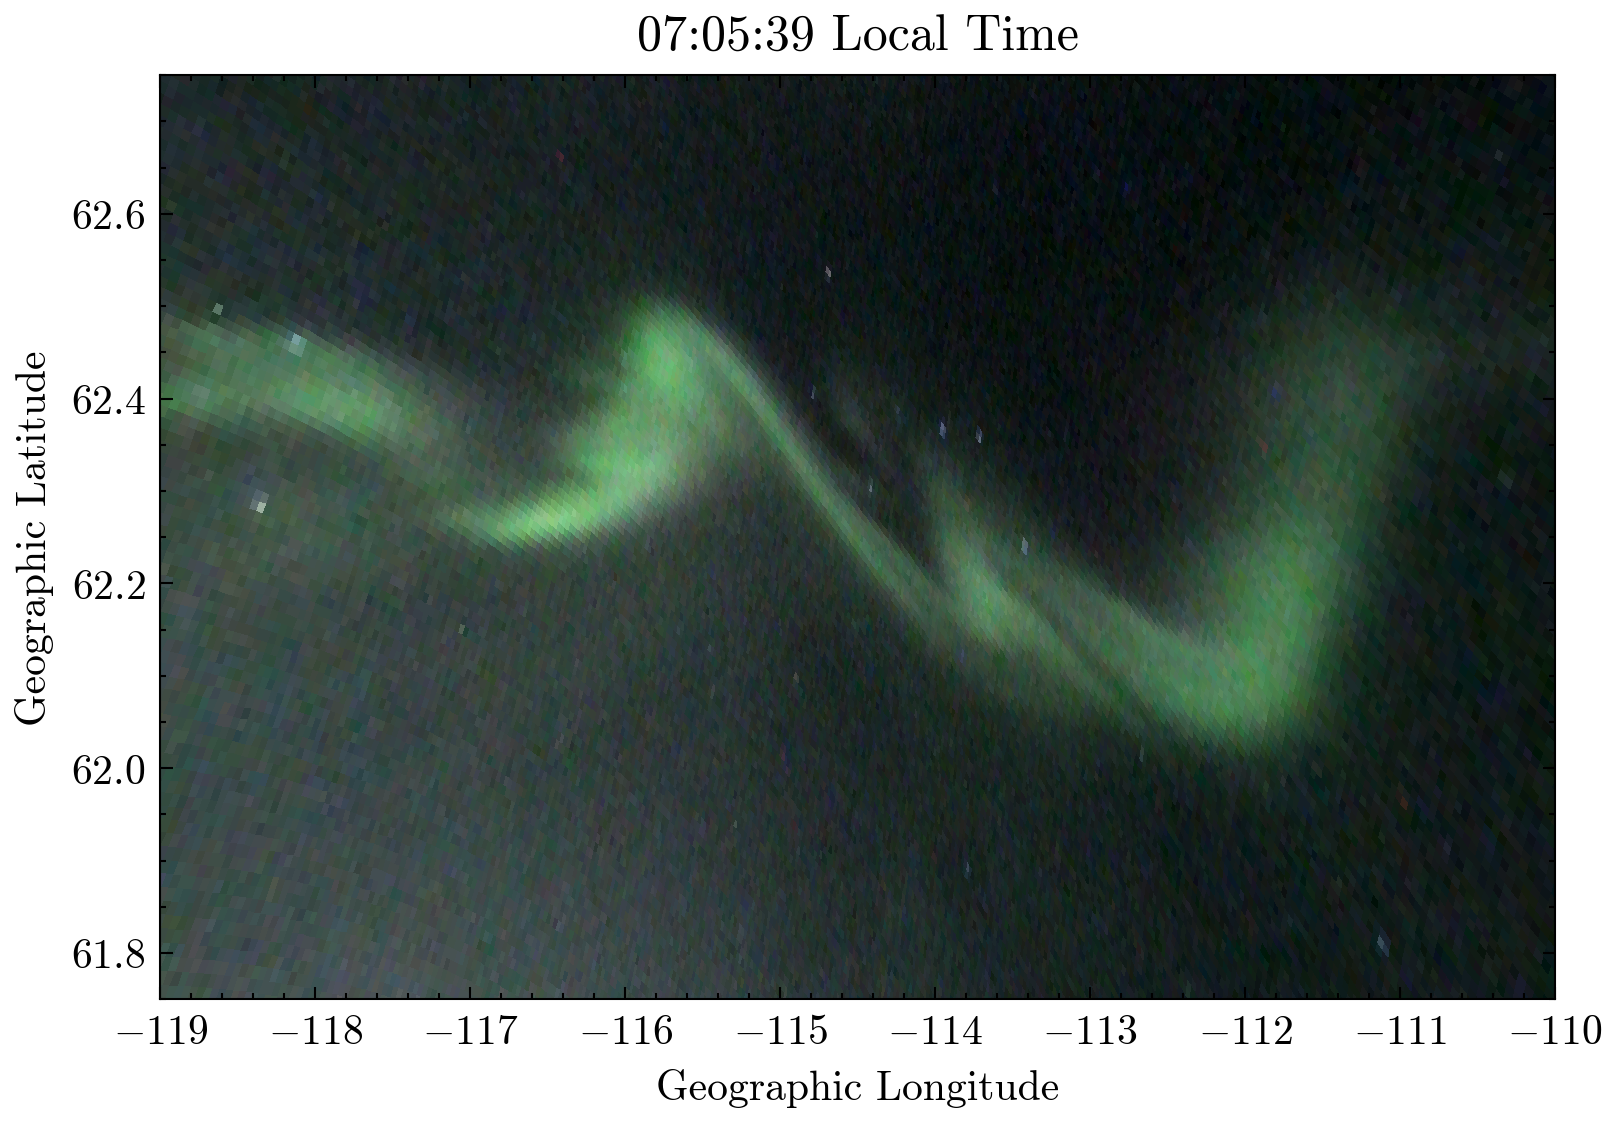

In [18]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)
asi_test=asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time=datetime(2022,12,19,14,5), colors='rgb', )
ax, im_good = asi_test.plot_map(ax=ax, asi_label=False)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]

ax.plot(sat_lla_E[1], sat_lla_E[0], linestyle='--', dashes=(5, 20), color='white') #length of 5, space of 20
plt.ylim(61.75, 62.75)
plt.xlim(-119, -110)
plt.xlabel("Geographic Longitude")
plt.ylabel("Geographic Latitude")
plt.title((datetime(2022,12,19,14,5, 39)-timedelta(hours=7)).strftime("%H:%M:%S")+ " Local Time")


Now this function takes in a grid of lats/lons and the satellite path in lat and lon and finds the closest pixels.

In [19]:


# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    # Reshape line_lats and line_lons for broadcasting with the grid
    line_lats_reshaped = line_lats[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)
    line_lons_reshaped = line_lons[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)

    # Compute squared Euclidean distances using broadcasting
    lat_diff = grid_lats[np.newaxis, :, :] - line_lats_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    lon_diff = grid_lons[np.newaxis, :, :] - line_lons_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    distances = lat_diff**2 + lon_diff**2  # Shape: (num_points, grid_lat_dim, grid_lon_dim)

    # Find the flat index of the minimum distance for each point along the grid axes
    min_indices_flat = np.argmin(distances.reshape(distances.shape[0], -1), axis=1)  # Shape: (num_points,)

    # Convert flat indices back to 2D grid indices for all points at once
    grid_shape = grid_lats.shape
    closest_indices = np.stack(np.unravel_index(min_indices_flat, grid_shape), axis=1)

    return closest_indices.T



Lets get the Pixel Intensity now each point of the track (spatiotemporal evolution)

In [ ]:
""" #Unfortunately, these break google cloud, these can be run locally; however,
we will just import the final results.

# Initialize ASI object
asi = asilib.asi.trex_rgb(location_code='yknf', alt=alt ,   time_range=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6)), )

indicies_sat=[]
pixel_closest_sat = np.zeros((40, 1920, 3), dtype=np.uint8)
movie_generator = asi.animate_map_gen()
time_sat_keo = []
lats_sat_keo=[]
for i, (time, image, _, im) in enumerate(movie_generator):
    indicies_sat.append(np.where((Etime >= np.datetime64(time)) & (Etime <= np.datetime64(time + timedelta(seconds=3))))[0])
    if i ==0:
        grid_lons = im.get_coordinates()[:, :, 0]
        grid_lats = im.get_coordinates()[:, :, 1]
        closest_indices_sat = np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0], sat_lla_E[1]))
        pixel_closest_sat[i] = ( image[closest_indices_sat[:, 0], closest_indices_sat[:, 1], :])
    else:
         pixel_closest_sat[i] = ( image[closest_indices_sat[:, 0], closest_indices_sat[:, 1], :])
    lats_sat_keo.append( sat_lla_E[0])
    time_sat_keo.append(time)
    if i==39: #due to an error on my own system related to ffmpeg
        break
"""


Now lets get the pixel intensity for the entire track for each shot of the camera (temporal, used for satellite aligned keogram)

In [ ]:
"""

# Initialize ASI object
asi = asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time_range=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6)), )


pixel_closest_sat_track = []
movie_generator = asi.animate_map_gen()
time_sat_alongtrack = []
indicies_sat_track =  []
lats=[]
for i, (time, image, _, im) in enumerate(movie_generator):
    indicies = np.where((Etime >= np.datetime64(time)) & (Etime <= np.datetime64(time + timedelta(seconds=3))))[0]
    indicies_sat_track.append(indicies)
    grid_lons = im.get_coordinates()[:, :, 0]
    grid_lats = im.get_coordinates()[:, :, 1]
    closest_indices_sat = np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0][indicies], sat_lla_E[1][indicies]))
    lats.append(sat_lla_E[0][indicies])
    pixel_closest_sat_track.append( image[closest_indices_sat[:, 0], closest_indices_sat[:, 1], :])

    if i==39:
        break
"""


Now taking our mag data, lets overplot the satellite track keogram with the the mag data (with a offset)

In [ ]:
import matplotlib.dates as mdates
fig_keo, ax = plt.subplots(figsize=(6,5), dpi=300, tight_layout=True)
im = plt.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

plt.ylim(62,62.8)

import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
cs = CubicSpline(Btime, sat_lla_B[0])
latitudes_16sps = cs(Etime)
cs = CubicSpline(Btime, BNEC[:,1])
Bs_16sps = cs(Etime)
u_zeros = np.zeros_like(-Bs_16sps)
print(np.max(np.abs(VNEC[:, 1])))
U_perpendicular = (-Bs_16sps-250) / 250  # Inverting y-component for perpendicular direction
V_perpendicular = (Bs_16sps+250)  / 250   # Keeping the x-component

QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=1, scale_units='inches', label="Eastward Velocity")
plt.quiverkey(QV1, 0.215, 0.875, 0.5, r'$250nT', labelpos='E', coordinates='figure', labelcolor='white')
cbar = plt.colorbar(im)
from datetime import datetime


locator = mdates.SecondLocator(interval=15)  # Shows every minute
formatter = mdates.DateFormatter('%M:%S')


ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', rotation=45)
ax.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
ax.set_xlabel("Time (M:S)")
ax.set_ylabel("Geographic Latitude")
cbar.set_label("Green Pixel Intensity")
ax.set_title("Satellite-Aligned Keogram")




Now Utilizing our code from Fig. 1 to get just the images, lets overplot the B field and the aurora and satellite track

In [ ]:
fig, axes = plt.subplots(figsize=(10,8), nrows=3, ncols=3, dpi=300, sharex=True, sharey=True, tight_layout=True)
axlist=axes.flatten()
time_array_pannel=[time_array[0]+timedelta(seconds=140)+timedelta(seconds=12*i) for i in range(9)]

for i in range(len(time_array_pannel)):
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array_pannel[i], colors='rgb', )

    asi.plot_map(ax=axlist[i], asi_label=False)
    axlist[i].set_title(time_array_pannel[i].strftime('%H:%M:%S%f')[:-6])
    axlist[i].set_xlim(-119,-109)
    axlist[i].set_ylim(61.75,63)
    axlist[i].plot(sat_lla_E[1], sat_lla_E[0], color='red', linestyle='dashed')

    axlist[i].quiver( sat_lla_E[1],sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=1, scale_units='inches', alpha=0.25)
    indicies= np.where((Etime >= np.datetime64(time_array_pannel[i] -  timedelta(seconds=5))) & (Etime <= np.datetime64(time_array_pannel[i] + timedelta(seconds=5))))[0]
    axlist[i].quiver(sat_lla_E[1][indicies], sat_lla_E[0][indicies],V_perpendicular[indicies], u_zeros[indicies], color='red', scale=1, scale_units='inches', label="Eastward Velocity", alpha=0.4)
    middle_index=np.argmin(np.abs(Etime -time_array_pannel[i]))
    axlist[i].scatter(sat_lla_E[1][middle_index], sat_lla_E[0][middle_index], color='white', s=15)



In [ ]:

fig, ax = plt.subplots(figsize=(5,3), dpi=300)
im = plt.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 ))
plt.ylim(62,63)


from scipy.interpolate import CubicSpline
cs = CubicSpline(Btime, sat_lla_B[0])
latitudes_16sps = cs(Etime)
cs = CubicSpline(Btime, BNEC[:,0])
Bs_16sps = cs(Etime)
U_perpendicular = -VNEC[:, 1] / np.max(np.abs(VNEC[:, 1]))  # Inverting y-component for perpendicular direction
V_perpendicular = VNEC[:, 1] / np.max(np.abs(VNEC[:, 1]))   # Keeping the x-component

plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=1, scale_units='inches')


locator = mdates.SecondLocator(interval=15)  # Shows every minute
formatter = mdates.DateFormatter('%M:%S')


ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', rotation=45)

In [ ]:
plt.plot( Bs_16sps)

Now lets make an ewogram

In [ ]:
lat16 = sat_lla_E[0]
lat50 = sat_lla_B[0]

In [ ]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [ ]:

alongtrackpixel=[]
lats_used=[]

alongtrackpixel = np.array(flatten_comprehension(pixel_closest_sat_track), dtype=np.uint8)
lats_used = np.array(flatten_comprehension(lats))


In [ ]:
fig, axes = plt.subplots(figsize=(3, 3), dpi=300, constrained_layout=True, sharex=True)
plt.plot(lats_used, alongtrackpixel[:, 1], label="Satellite Track Intensity")

In [ ]:
plt.pcolormesh(im_good.get_coordinates()[:, :, 0], im_good.get_coordinates()[:, :, 1],im_good.get_array())
plt.ylim(62,64)
plt.xlim(-120, -110)
plt.plot(sat_lla_E[1], sat_lla_E[0])
plt.plot(im_good.get_coordinates()[:, 300, 0], im_good.get_coordinates()[:, 300, 1])

In [ ]:

unique_latitudes, indices = np.unique(lats_used, return_index=True)
avg_pixel_intensity = np.array([np.mean(alongtrackpixel[:, 1][lats_used == lat]) for lat in unique_latitudes])
Etime_averaged= np.array(Etime[indicies])
# Create a cubic spline interpolator
spline = CubicSpline(unique_latitudes, avg_pixel_intensity)

# Create a finer grid of latitude values for smoother plotting
latitudes_dense_sat = np.linspace(unique_latitudes.min(), unique_latitudes.max(), 400)
smoothed_intensity_sat = spline(latitudes_dense_sat)

We want our plots to have lat verus data


In [ ]:

fig_data, axes = plt.subplots(figsize=(6,6), nrows=3, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='green')
Btwin.tick_params(axis='y', colors='green')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='green')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")


axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")




plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")

axes[0].legend(loc=3)
axes[1].legend(loc=3)
axes[2].legend(loc=3)

plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=1.2)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Channel Pixel Intensity", labelpad=20)

axes[0].set_xlim(62.25, 62.5)
axes[1].set_xlim(62.25, 62.5)
axes[2].set_xlim(62.25, 62.5)

axes[2].set_ylim(20,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)
Btwin.set_ylim(60,90)



Now synthesize both plots together, ie: satellite aligned keogram and insitu-data

In [ ]:

# Create a new figure
fig = plt.figure(figsize=(9.5, 6), dpi=300)  # Adjust figure size as needed
import matplotlib.gridspec as gridspec
# Define GridSpec with 1 column on the left and 3 stacked rows on the right
gs = gridspec.GridSpec(3, 2, figure=fig, wspace=0.275, hspace=0.125)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
ax1 = fig.add_subplot(gs[:, 1])  # Entire left column
ax1.tick_params(axis='both', colors='white', labelcolor='black')
def quiverplot():
    im = ax1.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax1.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,1])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(-Bs_16sps)
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = (-Bs_16sps-250) / 500  # Inverting y-component for perpendicular direction
    V_perpendicular = (Bs_16sps+250)  / 500   # Keeping the x-component

    QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=1, scale_units='inches', label="Eastward Velocity")
    ax1.quiverkey(QV1, 0.77, 0.82, 0.5, r'$250 nT$', labelpos='E', coordinates='figure', labelcolor='white')
    cbar = plt.colorbar(im)
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax1.set_xlabel("Time (M:S)", color='black')
    ax1.set_ylabel("Geographic Latitude", color='black')
    cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
    ax1.set_title("Satellite-Aligned Keogram", color='black')
quiverplot()




# Right column: 3 stacked rows
ax2 = fig.add_subplot(gs[0, 0])  # Top-right subplot
ax3 = fig.add_subplot(gs[1, 0])  # Middle-right subplot
ax4 = fig.add_subplot(gs[2, 0])  # Bottom-right subplot
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

axes=[ax2,ax3,ax4]
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
Btwin.tick_params(axis='y', colors='red')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")


axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")



axes[0].set_title("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")
axes[0].legend(loc=4)
axes[1].legend(loc=1)
axes[2].legend(loc=1)

plt.tight_layout(pad=0, w_pad=0.6, h_pad=0)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Pixel Intensity", labelpad=18)
axes[2].set_xlabel(r"Geographic Latitude")
import pandas as pd


axes[0].set_xlim(62.25, 63)
axes[1].set_xlim(62.25, 63)
axes[2].set_xlim(62.25, 63)

axes[2].set_ylim(22,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)
Btwin.set_ylim(0,170)

ax1.text(0.02, 0.98, "D)", transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.02, 0.98, "A)", transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax3.text(0.02, 0.98, "B)", transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax4.text(0.02, 0.98, "C)", transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# Display layout
plt.tight_layout()
plt.show()


In [ ]:

# Create a new figure
fig = plt.figure(figsize=(15, 8), dpi=300)  # Adjust figure size as needed

# Define GridSpec with 1 column on the left and 3 stacked rows on the right
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.25, hspace=0.125)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
ax1 = fig.add_subplot(gs[:, 1])  # Entire left column
ax1.tick_params(axis='both', colors='white', labelcolor='black')
ax2 = fig.add_subplot(gs[:, 2])  # Entire left column
ax2.tick_params(axis='both', colors='white', labelcolor='black')
def quiverplot_V():
    im = ax1.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax1.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,0])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(VNEC[:, 1])
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = -VNEC[:, 1] / 2000  # Inverting y-component for perpendicular direction
    V_perpendicular = VNEC[:, 1] / 2000   # Keeping the x-component

    QV1= ax1.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.75, scale_units='inches', label="Eastward Velocity")
    ax1.quiverkey(QV1, 0.46, 0.82, 0.5, r'$1000 \ \frac{\text{m}}{\text{s}}$', labelpos='E', coordinates='figure', labelcolor='white', transform=ax1.transAxes, fontproperties={"size": 13})
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax1.set_xlabel("Time (M:S)", color='black')
    ax1.set_ylabel("Geographic Latitude", color='black')
    ax1.set_title("Satellite-Aligned Keogram", color='black')

def quiverplot_B():
    im = ax2.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax2.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,1])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(-Bs_16sps)
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = (-Bs_16sps-250) / 250  # Inverting y-component for perpendicular direction
    V_perpendicular = (Bs_16sps+250)  / 250   # Keeping the x-component

    QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.8, scale_units='inches', label="Eastward Velocity")
    ax2.quiverkey(QV1, 0.8, 0.82, 0.5, r'$250 \text{nT}$', labelpos='E', coordinates='figure', labelcolor='white',transform=ax2.transAxes, fontproperties={"size": 13})
    cbar = plt.colorbar(im, pad=-0.035)
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax2.set_xlabel("Time (M:S)", color='black')
    cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
    ax2.set_title("Satellite-Aligned Keogram", color='black')
    plt.setp(ax2.get_yticklabels(), visible=False)
    pos = ax2.get_position()
    ax2.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    #pos = cbar.ax.get_position()
    #ax2.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

quiverplot_V()
quiverplot_B()
# Right column: 3 stacked rows
ax3 = fig.add_subplot(gs[0, 0])  # Top-right subplot
ax4 = fig.add_subplot(gs[1, 0])  # Middle-right subplot
ax5 = fig.add_subplot(gs[2, 0])  # Bottom-right subplot
ax6 = fig.add_subplot(gs[3, 0])  # Bottom-right subplot
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axes=[ax3,ax4,ax5, ax6]
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
Btwin.tick_params(axis='y', colors='red')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")


axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")


1

axes[0].set_title("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")
axes[0].legend(loc=4)
axes[1].legend(loc=1)
axes[2].legend(loc=1)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Pixel Intensity", labelpad=18)
axes[2].set_xlabel(r"Geographic Latitude")
import pandas as pd


axes[0].set_xlim(62.25, 63)
axes[1].set_xlim(62.25, 63)
axes[2].set_xlim(62.25, 63)

axes[2].set_ylim(22,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)
Btwin.set_ylim(0,170)

ax1.text(0.02, 0.98, "E)", transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.02, 0.98, "F)", transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax3.text(0.02, 0.98, "A)", transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax4.text(0.02, 0.98, "B)", transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.98, "C)", transform=ax5.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.98, "D)", transform=ax6.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')





Great now last step, we need make a periodogram from the interval of 63.4 to 63.3 of B in graph D

This is from the technique in Miles et al. 2018 where peridograms were used to detect the Ionospheric Alfven Resonator.

Although it should be okay, we will be using only the 50Hz data rather than downsampled 50Hz data

In [ ]:
indicies_between_3and4 = np.where((62.25 <= sat_lla_B[0]) & (63 >= sat_lla_B[0]))[0]
print(indicies_between_3and4)

In [ ]:
plt.plot(sat_lla_B[0][indicies_between_3and4], BNEC[indicies_between_3and4,1])

In [ ]:
import scipy.signal
print(int(len(BNEC[indicies_between_3and4,1])/50))
periodogram_data= scipy.signal.welch(BNEC[indicies_between_3and4,1], 50, detrend=None,scaling='spectrum', nperseg=50*6, window="hann")

cs = CubicSpline(Btime, BNEC)
Bs_16sps = cs(Etime)


indicies_between_3and4E = np.where((62.25 <= sat_lla_E[0]) & (63 >= sat_lla_E[0]))[0]

print(np.shape(ENEC))
periodogram_data_E= scipy.signal.welch(ENEC[indicies_between_3and4E,0], 16, detrend=None,scaling='spectrum', nperseg=16*6, window="hann")

In [ ]:
plt.plot(periodogram_data[0], np.sqrt(periodogram_data[1]), label='b50')
print(periodogram_data_E[0],periodogram_data[0])
print(len(periodogram_data_E[0]))
print(periodogram_data[0][:len(periodogram_data_E[0])])
plt.plot(periodogram_data_E[0], np.sqrt(periodogram_data_E[1]), label='e')
plt.yscale("log")
plt.xlim(0.5,8)
plt.ylim(3e-2,1e1)
plt.legend()


In [ ]:
print(periodogram_data[0][:len(periodogram_data_E[0])])
plt.plot(periodogram_data[0][:len(periodogram_data_E[0])], 10**(-3)/10**(-9)*np.sqrt(periodogram_data_E[1][:len(periodogram_data_E[0])]/(periodogram_data[1][:len(periodogram_data_E[0])])))
plt.yscale("log")
plt.ylim(1e5,1e9)


In [ ]:
Va=np.mean(10**(-3)/10**(-9)*np.sqrt(periodogram_data_E[1][:len(periodogram_data_E[0])]/(periodogram_data[1][:len(periodogram_data_E[0])])))
mu=4*np.pi*10e-7
Sigma_p=3
plt.plot(periodogram_data[0][:len(periodogram_data_E[0])], 10**(-3)/10**(-9)*np.sqrt(periodogram_data_E[1][:len(periodogram_data_E[0])]/(periodogram_data[1][:len(periodogram_data_E[0])])))
plt.yscale("log")
plt.axhline(1/(Sigma_p *mu))
plt.axhline(mu*Va**2*Sigma_p)

In [ ]:

# Create a new figure
fig = plt.figure(figsize=(14, 12), dpi=300)  # Adjust figure size as needed

# Define GridSpec with 1 column on the left and 3 stacked rows on the right
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.25, hspace=0.125)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
ax1 = fig.add_subplot(gs[:, 1])  # Entire left column
ax1.tick_params(axis='both', colors='white', labelcolor='black')
ax2 = fig.add_subplot(gs[:, 2])  # Entire left column
ax2.tick_params(axis='both', colors='white', labelcolor='black')
def quiverplot_V():
    im = ax1.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax1.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,0])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(VNEC[:, 1])
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = -VNEC[:, 1] / 2000  # Inverting y-component for perpendicular direction
    V_perpendicular = VNEC[:, 1] / 2000   # Keeping the x-component

    QV1= ax1.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.75, scale_units='inches', label="Eastward Velocity")
    ax1.quiverkey(QV1, 0.46, 0.82, 0.5, r'$1000 \ \frac{\text{m}}{\text{s}}$', labelpos='E', coordinates='figure', labelcolor='white', transform=ax1.transAxes, fontproperties={"size": 13})
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax1.set_xlabel("Time (M:S)", color='black')
    ax1.set_ylabel("Geographic Latitude", color='black')
    ax1.set_title("Satellite-Aligned Keogram", color='black')

def quiverplot_B():
    im = ax2.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax2.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,1])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(-Bs_16sps)
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = (-Bs_16sps-250) / 250  # Inverting y-component for perpendicular direction
    V_perpendicular = (Bs_16sps+250)  / 250   # Keeping the x-component

    QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.8, scale_units='inches', label="Eastward Velocity")
    ax2.quiverkey(QV1, 0.8, 0.82, 0.5, r'$250 \text{nT}$', labelpos='E', coordinates='figure', labelcolor='white',transform=ax2.transAxes, fontproperties={"size": 13})
    cbar = plt.colorbar(im, pad=-0.035)
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax2.set_xlabel("Time (M:S)", color='black')
    cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
    ax2.set_title("Satellite-Aligned Keogram", color='black')
    plt.setp(ax2.get_yticklabels(), visible=False)
    pos = ax2.get_position()
    ax2.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    #pos = cbar.ax.get_position()
    #ax2.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

quiverplot_V()
quiverplot_B()
# Right column: 3 stacked rows
ax3 = fig.add_subplot(gs[0, 0])  # Top-right subplot
ax4 = fig.add_subplot(gs[1, 0])  # Middle-right subplot
ax5 = fig.add_subplot(gs[2, 0])  # Bottom-right subplot
ax6 = fig.add_subplot(gs[3, 0], )  # Bottom-right subplot
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axes=[ax3,ax4,ax5, ax6]
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
Btwin.tick_params(axis='y', colors='red')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")


axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")



axes[0].set_title("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")
axes[0].legend(loc=4)
axes[1].legend(loc=1)
axes[2].legend(loc=1)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Pixel Intensity", labelpad=18)
axes[2].set_xlabel(r"Geographic Latitude")
import pandas as pd


axes[0].set_xlim(62.25, 63)
axes[1].set_xlim(62.25, 63)
axes[2].set_xlim(62.25, 63)

axes[2].set_ylim(22,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)

axes[3].plot(periodogram_data[0], np.sqrt(periodogram_data[1]))
axes[3].set_yscale("log")
axes[3].set_xlim(0,8)
axes[3].set_ylim(3e-2,1e1)
axes[3].set_ylabel("Amplitude Spectra of B (nT)", labelpad=8)
axes[3].set_xlabel("Frequency (Hz)")
pos = axes[3].get_position()
axes[3].set_position([pos.x0, pos.y0 -0.02, pos.width, pos.height])



Btwin.set_ylim(0,170)

ax1.text(0.02, 0.98, "E)", transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.02, 0.98, "F)", transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax3.text(0.02, 0.98, "A)", transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax4.text(0.02, 0.98, "B)", transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.98, "C)", transform=ax5.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax6.text(0.92, 0.98, "D)", transform=ax6.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')





In [ ]:

from scipy.signal import butter, filtfilt

# Parameters
fs = 50  # Sampling frequency in Hz
lowcut = 0.1  # Lower cutoff frequency (Hz)
highcut = 10.0  # Upper cutoff frequency (Hz)
order = 2

# Normalize the cutoff frequencies (relative to Nyquist frequency)
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

# Create Butterworth filter
b, a = butter(order, [low, high], btype='band')


# Apply zero-phase filtering
filtered_signal = filtfilt(b, a, BNEC[:, 1])

#plt.plot(lat50, BNEC[:, 1], label='Original Signal', alpha=0.5)
plt.plot(lat50, filtered_signal, label='Filtered Signal (0–8 Hz)')
#plt.xlim(62,63)

In [ ]:

# Create a new figure
fig = plt.figure(figsize=(14, 12), dpi=300)  # Adjust figure size as needed

# Define GridSpec with 1 column on the left and 3 stacked rows on the right
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.28, hspace=0.125)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
ax1 = fig.add_subplot(gs[:, 1])  # Entire left column
ax1.tick_params(axis='both', colors='white', labelcolor='black', which='both')
ax2 = fig.add_subplot(gs[:, 2])  # Entire left column
ax2.tick_params(axis='both', colors='white', labelcolor='black', which='both')
def quiverplot_V():
    im = ax1.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax1.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,0])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(VNEC[:, 1])
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = -VNEC[:, 1] / 2000  # Inverting y-component for perpendicular direction
    V_perpendicular = VNEC[:, 1] / 2000   # Keeping the x-component

    QV1= ax1.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.75, scale_units='inches', label="Eastward Velocity")
    ax1.quiverkey(QV1, 0.46, 0.82, 0.5, r'$1000 \ \frac{\text{m}}{\text{s}}$', labelpos='E', coordinates='figure', labelcolor='white', transform=ax1.transAxes, fontproperties={"size": 13})
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax1.set_xlabel("Time (M:S)", color='black')
    ax1.set_ylabel("Geographic Latitude", color='black')
    ax1.set_title("Satellite-Aligned Keogram", color='black')

def quiverplot_B():
    im = ax2.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax2.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime,  filtered_signal)
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(-Bs_16sps)
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = (-Bs_16sps) / 50  # Inverting y-component for perpendicular direction
    V_perpendicular = (Bs_16sps)  / 50   # Keeping the x-component

    QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.8, scale_units='inches', label="Eastward Velocity")
    ax2.quiverkey(QV1, 0.706, 0.82, 0.5, r'$50 \text{nT}$', labelpos='E', coordinates='figure', labelcolor='white',transform=ax2.transAxes, fontproperties={"size": 13})
    cbar = plt.colorbar(im, pad=-0.035)
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax2.set_xlabel("Time (M:S)", color='black')
    cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
    ax2.set_title("Satellite-Aligned Keogram", color='black')
    plt.setp(ax2.get_yticklabels(), visible=False)
    pos = ax2.get_position()
    ax2.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    #pos = cbar.ax.get_position()
    #ax2.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

quiverplot_V()
quiverplot_B()
# Right column: 3 stacked rows
ax3 = fig.add_subplot(gs[0, 0])  # Top-right subplot
ax4 = fig.add_subplot(gs[1, 0])  # Middle-right subplot
ax5 = fig.add_subplot(gs[2, 0])  # Bottom-right subplot
ax6 = fig.add_subplot(gs[3, 0], )  # Bottom-right subplot
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axes=[ax3,ax4,ax5, ax6]
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
Btwin.tick_params(axis='y', colors='red', which='both')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")
Btwin.plot(lat50, filtered_signal, label=r'Filter $B_{E}$ (0.1-8 Hz)', color='red', linestyle='--')
axes[1].plot(lat50, filtered_signal, label=r'Filtered $B_{E}$ (0.1-8 Hz)', color='red', linestyle='--')
axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")



axes[0].set_title("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")
axes[0].legend(loc=4)
axes[1].legend(loc=1)
axes[2].legend(loc=1)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Pixel Intensity", labelpad=18)
axes[2].set_xlabel(r"Geographic Latitude")
import pandas as pd


axes[0].set_xlim(62.25, 63)
axes[1].set_xlim(62.25, 63)
axes[2].set_xlim(62.25, 63)

axes[2].set_ylim(22,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)

axes[3].plot(periodogram_data[0], np.sqrt(periodogram_data[1]))
axes[3].set_yscale("log")
axes[3].set_xlim(0,8)
axes[3].set_ylim(3e-2,1e1)
axes[3].set_ylabel("Amplitude Spectra of B (nT)", labelpad=8)
axes[3].set_xlabel("Frequency (Hz)")
pos = axes[3].get_position()
axes[3].set_position([pos.x0, pos.y0 -0.02, pos.width, pos.height])



Btwin.set_ylim(-50,130)

ax1.text(0.02, 0.98, "E)", transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.02, 0.98, "F)", transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax3.text(0.02, 0.98, "A)", transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax4.text(0.02, 0.98, "B)", transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.98, "C)", transform=ax5.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax6.text(0.92, 0.98, "D)", transform=ax6.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')





In [ ]:
plt.plot(periodogram_data[0], np.sqrt(periodogram_data[1]))

periodogram_data= scipy.signal.welch(filtered_signal[indicies_between_3and4], 50, detrend=None,scaling='spectrum', nperseg=50*6, window="hann")
plt.plot(periodogram_data[0], np.sqrt(periodogram_data[1]))

plt.yscale("log")
plt.xlim(0,10)
plt.ylim(1e-2, 1e2)

In [ ]:

# Create a new figure
fig = plt.figure(figsize=(14, 12), dpi=300)  # Adjust figure size as needed

# Define GridSpec with 1 column on the left and 3 stacked rows on the right
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.28, hspace=0.125)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
ax1 = fig.add_subplot(gs[:, 1])  # Entire left column
ax1.tick_params(axis='both', colors='white', labelcolor='black', which='both')
ax2 = fig.add_subplot(gs[:, 2])  # Entire left column
ax2.tick_params(axis='both', colors='white', labelcolor='black', which='both')
def quiverplot_V():
    im = ax1.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax1.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime, BNEC[:,0])
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(VNEC[:, 1])
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = -VNEC[:, 1] / 2000  # Inverting y-component for perpendicular direction
    V_perpendicular = VNEC[:, 1] / 2000   # Keeping the x-component

    QV1= ax1.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.75, scale_units='inches', label="Eastward Velocity")
    ax1.quiverkey(QV1, 0.46, 0.82, 0.5, r'$1000 \ \frac{\text{m}}{\text{s}}$', labelpos='E', coordinates='figure', labelcolor='white', transform=ax1.transAxes, fontproperties={"size": 13})
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax1.set_xlabel("Time (M:S)", color='black')
    ax1.set_ylabel("Geographic Latitude", color='black')
    ax1.set_title("Satellite-Aligned Keogram", color='black')

def quiverplot_B():
    im = ax2.pcolormesh( time_sat_keo, sat_lla_E[0], np.swapaxes(pixel_closest_sat, 1, 0 )[:,:,1], vmin=30, vmax=50)

    ax2.set_ylim(62,62.8)


    from scipy.interpolate import CubicSpline
    cs = CubicSpline(Btime, sat_lla_B[0])
    latitudes_16sps = cs(Etime)
    cs = CubicSpline(Btime,  filtered_signal)
    Bs_16sps = cs(Etime)
    u_zeros = np.zeros_like(-Bs_16sps)
    print(np.max(np.abs(VNEC[:, 1])))
    U_perpendicular = (-Bs_16sps) / 50  # Inverting y-component for perpendicular direction
    V_perpendicular = (Bs_16sps)  / 50   # Keeping the x-component

    QV1= plt.quiver( Etime,sat_lla_E[0], V_perpendicular, u_zeros, color='white', scale=0.8, scale_units='inches', label="Eastward Velocity")
    ax2.quiverkey(QV1, 0.706, 0.82, 0.5, r'$50 \text{nT}$', labelpos='E', coordinates='figure', labelcolor='white',transform=ax2.transAxes, fontproperties={"size": 13})
    pos = ax.get_position()

    # Create new axes for colorbar: same height, but narrow width
    cbar_width = 0.02  # This controls how thin the colorbar is
    cbar_padding = -0.02  # Space between plot and colorbar

    cbar_ax = fig.add_axes([
        pos.x1 + cbar_padding,  # x-position (right of main plot)
        pos.y0,                 # y-position (same as main plot)
        cbar_width,             # width (THIN!)
        pos.height              # height (same as main plot)
    ])

    # Create the colorbar in that axis
    cbar= fig.colorbar(im, cax=cbar_ax)
    from datetime import datetime


    locator = mdates.SecondLocator(interval=15)  # Shows every minute
    formatter = mdates.DateFormatter('%M:%S')


    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xlim(datetime(2022,12,19,14,4), datetime(2022,12,19,14,5,45))
    ax2.set_xlabel("Time (M:S)", color='black')
    cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
    ax2.set_title("Satellite-Aligned Keogram", color='black')
    plt.setp(ax2.get_yticklabels(), visible=False)
    pos = ax2.get_position()
    ax2.set_position([pos.x0 - 0.04, pos.y0, pos.width, pos.height])
    #pos = cbar.ax.get_position()
    #ax2.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

quiverplot_V()
quiverplot_B()
# Right column: 3 stacked rows
ax3 = fig.add_subplot(gs[0, 0])  # Top-right subplot
ax4 = fig.add_subplot(gs[1, 0])  # Middle-right subplot
ax5 = fig.add_subplot(gs[2, 0])  # Bottom-right subplot
ax6 = fig.add_subplot(gs[3, 0], )  # Bottom-right subplot
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
axes=[ax3,ax4,ax5, ax6]
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")





Btwin=axes[1].twinx()
Btwin.plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
Btwin.tick_params(axis='y', colors='red', which='both')
axes[1].plot(lat50,BNEC[:,0], label=r"$B_{N}$", color='red')
axes[1].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")
Btwin.plot(lat50, filtered_signal, label=r'Filter $B_{E}$ (0.1-8 Hz)', color='red', linestyle='--')
axes[1].plot(lat50, filtered_signal, label=r'Filtered $B_{E}$ (0.1-8 Hz)', color='red', linestyle='--')
axes[2].plot(latitudes_dense_sat, smoothed_intensity_sat, label="Satellite Track ")



axes[0].set_title("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig_data.supxlabel("Latitude")
#axes[0].legend(loc=4)
axes[1].legend(loc=1)
#axes[2].legend(loc=1)

axes[0].set_ylabel(r"Ion Velocities East (m/s)")
axes[1].set_ylabel(r"Magnetic Field (nT)")
axes[2].set_ylabel(r"Green Pixel Intensity", labelpad=18)
axes[2].set_xlabel(r"Geographic Latitude")
import pandas as pd


axes[0].set_xlim(62.25, 63)
axes[1].set_xlim(62.25, 63)
axes[2].set_xlim(62.25, 63)

axes[2].set_ylim(22,50)
axes[1].set_ylim(-420,-250)
axes[0].set_ylim(-500, 1500)

axes[3].plot(periodogram_data[0], np.sqrt(periodogram_data[1]))
axes[3].set_yscale("log")
axes[3].set_xlim(0,8)
axes[3].set_ylim(3e-2,3e1)
axes[3].set_ylabel("Amplitude Spectra of B (nT)", labelpad=8)
axes[3].set_xlabel("Frequency (Hz)")
pos = axes[3].get_position()
axes[3].set_position([pos.x0, pos.y0 -0.02, pos.width, pos.height])



Btwin.set_ylim(-50,130)

ax1.text(0.02, 0.99, "e)", transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax2.text(0.02, 0.99, "f)", transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='left', color='white')
ax3.text(0.02, 0.98, "a)", transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax4.text(0.02, 0.98, "b)", transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.98, "c)", transform=ax5.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
ax6.text(0.92, 0.98, "d)", transform=ax6.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')



